In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import webbrowser
import io
import pandas as pd
from time import sleep
from selenium import webdriver
from parsel import Selector
import csv
import os
import requests
from bs4 import BeautifulSoup

driver = webdriver.Chrome(r"C:\chromedriver.exe")     #change to your path\to\chromedriver.exe or geckodriver.exe
driver.get( 'https://www.tripadvisor.fr/Restaurant_Review-g187147-d5981796-Reviews-Kfc-Paris_Ile_de_France.html')


def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
         f.write(content)
         webbrowser.open(filename)


def get_soup(session, url, show=False):
    r = session.get(url)
    if show:
        display(r.content, 'temp.html')
    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')


def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)

    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')

def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })


    items = parse(session, url)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    num_reviews = num_reviews[1:-1] 
    num_reviews = num_reviews.replace(',', '')
    num_reviews = int(num_reviews) # convert text into integer
    print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    while(True):
        subpage_url = url_template.format(offset)

        subpage_items = parse_reviews(session, subpage_url)
        if not subpage_items:
            break

        items += subpage_items

        if len(subpage_items) < 5:
            break

        offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids

def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/OverlayWidgetAjax?Mode=EXPANDED_HOTEL_REVIEWS_RESP&metaReferer=Hotel_Review'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', class_='header heading masthead masthead_h1').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    soup = get_more(session, reviews_ids)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    items = []

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
        
        #test=soup.find_all('div', class_='memberOverlayRedesign')
        #username_test=test.find('div', class_='username').text
        #other_test=test.find('ul', class_='memberdescriptionReviewEnhancements').text
        
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]
        reviewer_name=str(review.find('div', class_='info_text pointer_cursor').div)
        l=len(reviewer_name)
        reviewer_name=reviewer_name[5:l-6]
        if (review.find('div', class_={'userLoc':True})):
            reviewer_location=str(review.find('div', class_='userLoc').strong)
            ll=len(reviewer_location)
            reviewer_location=reviewer_location[8:ll-9]
        else: 
            reviewer_location="NA"

        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
            'reviewer_name': reviewer_name,
            'reviewer_location': reviewer_location,
            'bubble_rating': bubble_rating[0],
            'review_title': review.find('span', class_='noQuotes').text,
            
            #'test1': username_test,
            #'test2': other_test,
       }

        items.append(item)
        print('\n--- review ---\n')
        for key,val in item.items():
            print(' ', key, ':', val)

    print()

    return items

def write_in_csv(items, filename='results.csv',
                  headers=['hotel name', 'review title', 'review body',
                           'review date', 'contributions', 'helpful vote',
                           'user name' , 'user location', 'rating'],
              mode='w'):

    print('--- CSV ---')

    with io.open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)

        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'
DB_COLUMN2   ='review_title'
DB_COLUMN3   ='reviewer_name'
DB_COLUMN4   ='bubble_rating'
DB_COLUMN5   ='reviewer_location'
#DB_COLUMN6   ='test2'
start_urls = [
    'https://www.tripadvisor.fr/Restaurant_Review-g187147-d5981796-Reviews-Kfc-Paris_Ile_de_France.html',
]

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1,
    DB_COLUMN2,
    DB_COLUMN3,
    DB_COLUMN4,
    DB_COLUMN5,
    #DB_COLUMN6,
]

lang = 'it'


for url in start_urls:

    # get all reviews for 'url' and 'lang'
    items = scrape(url)

    if not items:
        print('No reviews')
    else:
        # write in CSV
        filename = url.split('Reviews-')[1][:-5]
        print('filename:', filename)
        write_in_csv(items, filename + '.csv', headers, mode='w')

[parse] url: https://www.tripadvisor.fr/Restaurant_Review-g187147-d5981796-Reviews-Kfc-Paris_Ile_de_France.html


In [ ]:
import pandas as pd


In [ ]:
df = pd.read_csv("KFC_france.csv")

In [ ]:
df.head()

,review_body,review_date,review_title,reviewer_name,bubble_rating,reviewer_location
0,Did I happen to say they are rude? Hmm. Unders...,"October 1, 2019",Rude. Ignorant. Dirty.,HonestEdinburgh,1,"Edinburgh, United Kingdom"
1,"Tuesday offers are well worth the euro's, 11 T...","August 3, 2019",Tuesday offer,GarryF965,5,"Doncaster, United Kingdom"
2,"They only sell wings, tenders, sandwiches....n...","June 22, 2019",No Chicken Pieces!,SinclairDC,2,"Washington DC, District of Columbia"
3,"It was great , clean tidy, with hot tasty food...","August 10, 2018",Loved it,Cjjp65,4,"Livingston, United Kingdom"
4,The worst KFC ever. No cleaning and garbage fu...,"July 9, 2018",Terrible,Janooooo,1,"Fredrikstad, Norway"


In [ ]:
import datetime
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
import string
from gensim import corpora, models, similarities
import time
import operator

In [ ]:
# -*- coding: utf-8 -*-
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.lower()
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if ";" in text: text = text.replace(";\"","\";")    
    #text = text.replace(".",".<stop>")
    #text = text.replace(";",";<stop>")
    #text = text.replace("?","?<stop>")
    #text = text.replace("!","!<stop>")
    #text = text.replace("<prd>",".")
    #sentences = text.split("<stop>")
    #sentences = sentences[:-1]
    #sentences = [s.strip() for s in sentences]
    return text

In [ ]:
content = df.review_body
content

0      Did I happen to say they are rude? Hmm. Unders...
1      Tuesday offers are well worth the euro's, 11 T...
2      They only sell wings, tenders, sandwiches....n...
3      It was great , clean tidy, with hot tasty food...
4      The worst KFC ever. No cleaning and garbage fu...
                             ...                        
665    After a long day touring Versailles, we didn't...
666    Chips were cold but were replaced. Hot wicks a...
667    Ordered large fries, 3 chicken pieces and 3 ho...
668    It was very crowded and loud due to all the st...
669     We tried here as opposed to McDonalds as it w...
Name: review_body, Length: 670, dtype: object

In [ ]:
phrases = []
for ph in content:
    phrases.append(split_into_sentences(ph))

In [ ]:
phrases

[' did i happen to say they are rude? hmm. understatement of the year.seriously please do not bother.oh and they obviously do not have the same levels of cleanliness we have in the uk. the staff member who ignored me was dirty and floor littered with food debris.some of the staff seriously need to find a new job as they obviously absolutely hate this one , given the disdain they have towards their customers. avoid, please please avoid.a food health disaster  ',
 " tuesday offers are well worth the euro's, 11 tenders and 3 sauces for €6.95. staff speak english for those that don't speak french.   ",
 ' they only sell wings, tenders, sandwiches....no drumsticks, thighs, or breasts! and nothing with original recipe! this place is an embarrassment to kfc. i would have left, but my daughter had been looking forward to kfc for the entire train trip.  ',
 " it was great , clean tidy, with hot tasty food , i'm not big on fast food but i must admit i did enjoy  ",
 ' the worst kfc ever. no clea

In [ ]:
data_clean = pd.DataFrame(phrases)
data_clean.columns = ['The review']
data_clean

,The review
0,did i happen to say they are rude? hmm. under...
1,"tuesday offers are well worth the euro's, 11 ..."
2,"they only sell wings, tenders, sandwiches......."
3,"it was great , clean tidy, with hot tasty foo..."
4,the worst kfc ever. no cleaning and garbage f...
...,...
665,"after a long day touring versailles, we didn'..."
666,chips were cold but were replaced. hot wicks ...
667,"ordered large fries, 3 chicken pieces and 3 h..."
668,it was very crowded and loud due to all the s...


In [ ]:
filtering_data = []
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))

In [ ]:
for stop_words in phrases:
    filtered_sentence = [w for w in stop_words if not w in stopWords]
    filtering_data.append(filtered_sentence)

In [ ]:
data_clean1=data_clean[["The review"]]
data_clean1["bubble_rating"]=df["bubble_rating"]

In [ ]:
data_clean1

,The review,bubble_rating
0,did i happen to say they are rude? hmm. under...,1
1,"tuesday offers are well worth the euro's, 11 ...",5
2,"they only sell wings, tenders, sandwiches.......",2
3,"it was great , clean tidy, with hot tasty foo...",4
4,the worst kfc ever. no cleaning and garbage f...,1
...,...,...
665,"after a long day touring versailles, we didn'...",5
666,chips were cold but were replaced. hot wicks ...,4
667,"ordered large fries, 3 chicken pieces and 3 h...",1
668,it was very crowded and loud due to all the s...,2


In [ ]:
data_clean1.describe()

,bubble_rating
count,670.000000
mean,1.825373
std,1.317111
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


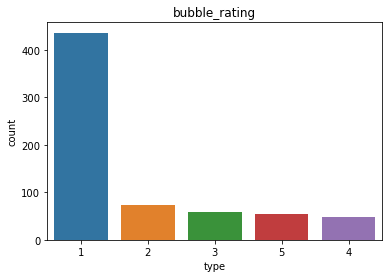

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(
  x='bubble_rating',
  data=data_clean1,
  order=data_clean1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating");

In [ ]:
print("Rating"" ""Totale")
print(data_clean1.bubble_rating.value_counts())

Rating Totale
1    436
2     73
3     58
5     55
4     48
Name: bubble_rating, dtype: int64


### Interprétation:

On remarque que 48 des clients ont donné une note=4 et 436 clients ont noté KFC France avec une note=1 puis on trouve que 58  clients ont donné une note=3. Et cette répartition nous permet de déduire 2 intérprétations:
* Ce résultat confirme le résultat précédent de la moyenne et la médiane et qui sont = 2.
* On peut dire que la majorité des clients ne sont satisfaits par les services de KFC france puisque le nombre totale des clients qui ont donné une note <=3 est égal à 567 tandis que le nombre des clients qui ont donné une note supérieure à 3 est égal à 103.  Donc on peut dire que l'image est très négative pour les  clients.

In [ ]:
data_clean1["review_type"] = data_clean1["bubble_rating"].apply(
  lambda x: "bad" if x < 3 else "good"
)

In [ ]:
data_clean1.review_type.value_counts()

bad     509
good    161
Name: review_type, dtype: int64

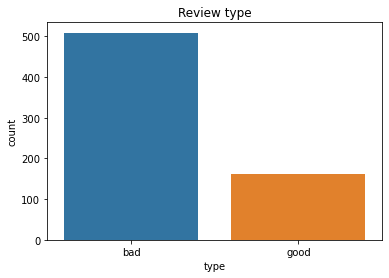

In [ ]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean1,
  order=data_clean1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

### Interprétation:

* Comme on la déjà mentionnée dans l'interprétation précedente on peut dire que d'une manière générale la E-réputation de KFC est négative puisque le nombre de mauvais retour dépasse le nombre de bon retours.


### 2 ème méthode: Word Cloud

* Afin de déterminer les facteurs qui ont abouti à la constuction de cette E-réputation de KFC France, on va réaliser deux WordCloud (une pour les reviews positives et une pour les négatives) qui vont nous permettre de dégager les mots les plus fréquentes dans chacun des cas et donc déduire les facteurs agissants sur l'image de KFC. 

In [ ]:
good_reviews = data_clean1[data_clean1.review_type == "good"]
bad_reviews = data_clean1[data_clean1.review_type == "bad"]

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

good_reviews_text = " ".join(good_reviews["The review"].to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews["The review"].to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text)

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def show_word_cloud(cloud, title):
  plt.figure(figsize = (16, 10))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

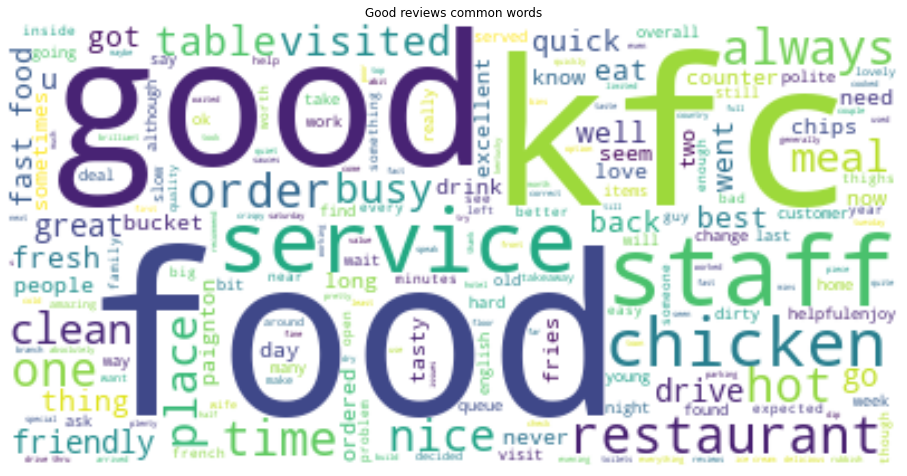

In [ ]:
show_word_cloud(good_reviews_cloud, "Good reviews common words")


### Interprétation

D'après ce word cloud, on remarque que les mots les plus fréquents dans les retours positifs peuvent etre classés dans 3 groupes:
* "chicken, meal,fries, drink, large..": les produits de KFC
* "clean,place,helpful,lovely,fresh,people,staff,fast,friendly, quick, service , cheap, price": les services, le comportement du staff , l'hygiène, le temps d'attente réduit, le bas prix.

=> et ceci nous permet de dire que ces derniers  sont les facteurs qui ont contribué le plus à cette image positive de KFC.

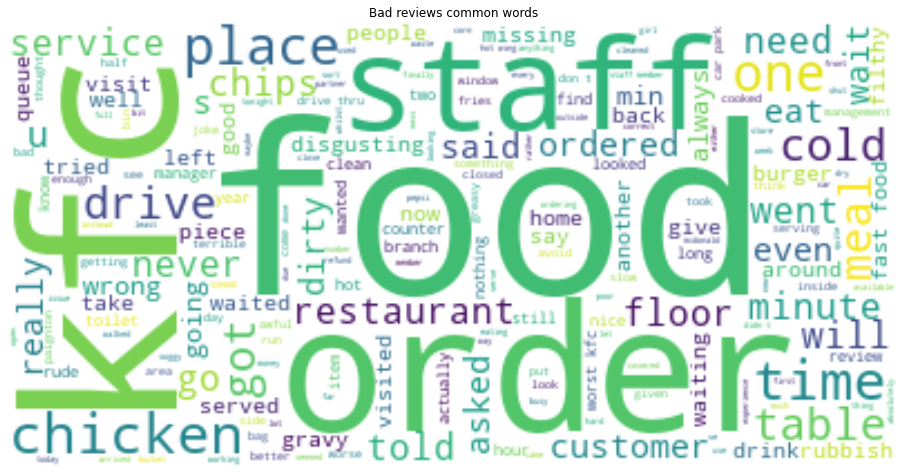

In [ ]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words")

### Interprétation:

D'après ce word cloud, on remarque que les mots les plus fréquents dans les retours négatifs peuvent etre classés dans 3 groupes:
* "cold,ordered,time,wait..": le temps d'attente lors des commandes
* "chicken,chips,drink,burger..": qualité des produits de KFC
* "toilet,dirty,bathroom...": l'hygiène dans KFC
* "rude, staff, manager," les services (certains employés ont manifesté des signes d'impolitesse)

=> Afin d'éviter les mauvais retours, KFC France doit agir sur ces aspects et ceci lui permettra l'amélioration de sa réputation.

## 3 ème méthode: Evaluation de l'image de KFC France en focalusiant sur les textes "des reviews"

* Nous allons maintenant analyser les textes écrits par les clients de KFC France et non pas sur la note attribuée et comparer les résultats qu'on va les obtenir avec les résultats précédents.
* On va utiliser TEXTBLOB afin d'obtenir une note de polarité

In [ ]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean['polarity'] = data_clean['The review'].apply(pol)
data_clean['subjectivity'] = data_clean['The review'].apply(sub)
data_clean["Reviewer Name"]=df["reviewer_name"]
data_clean

,The review,polarity,subjectivity,Reviewer Name
0,did i happen to say they are rude? hmm. under...,-0.270996,0.578030,HonestEdinburgh
1,"tuesday offers are well worth the euro's, 11 ...",0.100000,0.025000,GarryF965
2,"they only sell wings, tenders, sandwiches.......",0.117188,0.593750,SinclairDC
3,"it was great , clean tidy, with hot tasty foo...",0.373810,0.614286,Cjjp65
4,the worst kfc ever. no cleaning and garbage f...,-0.295833,0.612500,Janooooo
...,...,...,...,...
665,"after a long day touring versailles, we didn'...",0.214286,0.550000,Soung-Phoenix
666,chips were cold but were replaced. hot wicks ...,-0.163889,0.643056,GPhillipsMBE
667,"ordered large fries, 3 chicken pieces and 3 h...",-0.104464,0.466071,Seaskewer
668,it was very crowded and loud due to all the s...,0.075000,0.515000,Maurice M


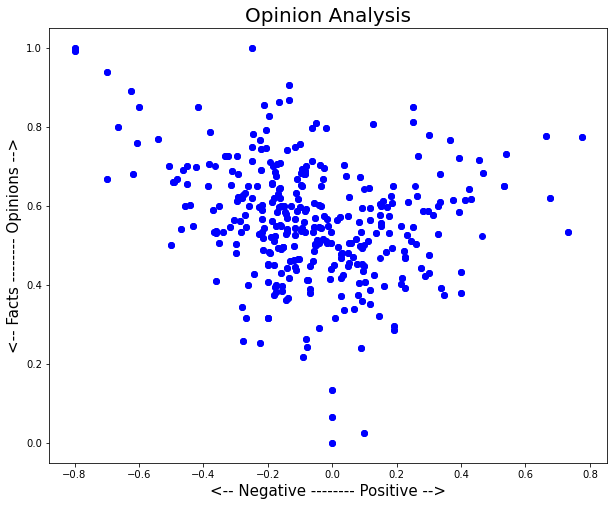

In [ ]:
# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean.index):
    x = data_clean.polarity.loc[index]
    y = data_clean.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

### Interprétation:

En analysant les points qu'on a obtenu et ceci par rapport à l'axe des abscisse:
* la majorité des points sont entre 0 et -1 avec 0 représente un avis plus au moins neutre et en allant vers -1 les retours deviennent de plus en plus négatifes. Alors un point d'abscisse 1 est un point représentant un avis très positive. Et inversement en allant vers -1.
* Plus précisement la majorité des points sont entre 0 et -0.4.

=> Donc d'une manière générale on peut dire que les retours sur KFC France sont négatives.Puisqu'ils sont entre 0 et -0.5 ces clients donne un retour négatives mais il n'est pas totoalement mécontent. Alors dans ces retours en trouvera bien évidémment des mots de satisfaction par rapport à quelques services que le décideurs de KFC France doivent le prendre en considération afin de plus améliorer la réputation de KFC et diminuer les opinions négatives .


=> Ce résultat confirme les interprétations qu'on a déjà dégagé par les autres méthodes.

# Objectif 3

* La position de KFC France par rapport à ses concurrents

### Web scraping: Burger King

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import webbrowser
import io
import pandas as pd
from time import sleep
from selenium import webdriver
from parsel import Selector
import csv
import os
import requests
from bs4 import BeautifulSoup


#faz login no linkedin


driver = webdriver.Chrome(r"C:\chromedriver.exe")     #change to your path\to\chromedriver.exe or geckodriver.exe
driver.get('https://www.tripadvisor.com/Restaurant_Review-g187147-d5800727-Reviews-Burger_King-Paris_Ile_de_France.html')

def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
         f.write(content)
    webbrowser.open(filename)


def get_soup(session, url, show=False):
    r = session.get(url)
    if show: 
        display(r.content, 'temp.html')
    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')


def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)

    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')

def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })


    items = parse(session, url)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    num_reviews = num_reviews[1:-1] 
    num_reviews = num_reviews.replace(',', '')
    num_reviews = int(num_reviews) # convert text into integer
    print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    while(True):
        subpage_url = url_template.format(offset)

        subpage_items = parse_reviews(session, subpage_url)
        if not subpage_items:
            break

        items += subpage_items

        if len(subpage_items) < 5:
            break

        offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids

def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/OverlayWidgetAjax?Mode=EXPANDED_HOTEL_REVIEWS_RESP&metaReferer=Hotel_Review'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', class_='header heading masthead masthead_h1').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    soup = get_more(session, reviews_ids)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    items = []

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
        
        #test=soup.find_all('div', class_='memberOverlayRedesign')
        #username_test=test.find('div', class_='username').text
        #other_test=test.find('ul', class_='memberdescriptionReviewEnhancements').text
        
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]
        reviewer_name=str(review.find('div', class_='info_text pointer_cursor').div)
        l=len(reviewer_name)
        reviewer_name=reviewer_name[5:l-6]
        if (review.find('div', class_={'userLoc':True})):
            reviewer_location=str(review.find('div', class_='userLoc').strong)
            ll=len(reviewer_location)
            reviewer_location=reviewer_location[8:ll-9]
        else: 
            reviewer_location="NA"

        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
            'reviewer_name': reviewer_name,
            'reviewer_location': reviewer_location,
            'bubble_rating': bubble_rating[0],
            'review_title': review.find('span', class_='noQuotes').text,
            
            #'test1': username_test,
            #'test2': other_test,
       }

        items.append(item)
        print('\n--- review ---\n')
        for key,val in item.items():
            print(' ', key, ':', val)

    print()

    return items

def write_in_csv(items, filename='results.csv',
                  headers=['hotel name', 'review title', 'review body',
                           'review date', 'contributions', 'helpful vote',
                           'user name' , 'user location', 'rating'],
              mode='w'):

    print('--- CSV ---')

    with open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)

        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'
DB_COLUMN2   ='review_title'
DB_COLUMN3   ='reviewer_name'
DB_COLUMN4   ='bubble_rating'
DB_COLUMN5   ='reviewer_location'
#DB_COLUMN6   ='test2'
start_urls = [
    'https://www.tripadvisor.com/Restaurant_Review-g187147-d5800727-Reviews-Burger_King-Paris_Ile_de_France.html',
    
]

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1,
    DB_COLUMN2,
    DB_COLUMN3,
    DB_COLUMN4,
    DB_COLUMN5,
    #DB_COLUMN6,
]

lang = 'it'


for url in start_urls:

    # get all reviews for 'url' and 'lang'
    items = scrape(url)

    if not items:
        print('No reviews')
    else:
        # write in CSV
        filename = url.split('Reviews-')[1][:-5]
        print('filename:', filename)
        write_in_csv(items, filename + '.csv', headers, mode='w')

<ipython-input-66-2621df41514d>:19: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"C:\chromedriver.exe")     #change to your path\to\chromedriver.exe or geckodriver.exe


[parse] url: https://www.tripadvisor.com/Restaurant_Review-g187147-d5800727-Reviews-Burger_King-Paris_Ile_de_France.html


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import webbrowser
import io
import pandas as pd
from time import sleep
from selenium import webdriver
from parsel import Selector
import csv
import os
import requests
from bs4 import BeautifulSoup

driver = webdriver.Chrome(r"C:\chromedriver.exe")     #change to your path\to\chromedriver.exe or geckodriver.exe
driver.get( 'https://www.tripadvisor.com/Restaurant_Review-g187147-d1080856-Reviews-McDonalds_Champs_Elysees-Paris_Ile_de_France.html')
def display(content, filename='output.html'):
    with open(filename, 'wb') as f:
         f.write(content)
         webbrowser.open(filename)


def get_soup(session, url, show=False):
    r = session.get(url)
    if show:
        display(r.content, 'temp.html')
    if r.status_code != 200: # not OK
        print('[get_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')


def post_soup(session, url, params, show=False):
    '''Read HTML from server and convert to Soup'''

    r = session.post(url, data=params)

    if show:
        display(r.content, 'temp.html')

    if r.status_code != 200: # not OK
        print('[post_soup] status code:', r.status_code)
    else:
        return BeautifulSoup(r.text, 'html.parser')

def scrape(url, lang='ALL'):

    # create session to keep all cookies (etc.) between requests
    session = requests.Session()

    session.headers.update({
        'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:57.0) Gecko/20100101 Firefox/57.0',
    })


    items = parse(session, url)

    return items

def parse(session, url):
    '''Get number of reviews and start getting subpages with reviews'''

    print('[parse] url:', url)

    soup = get_soup(session, url)

    if not soup:
        print('[parse] no soup:', url)
        return

    num_reviews = soup.find('span', class_='reviews_header_count').text # get text
    num_reviews = num_reviews[1:-1] 
    num_reviews = num_reviews.replace(',', '')
    num_reviews = int(num_reviews) # convert text into integer
    print('[parse] num_reviews ALL:', num_reviews)

    url_template = url.replace('.html', '-or{}.html')
    print('[parse] url_template:', url_template)

    items = []

    offset = 0

    while(True):
        subpage_url = url_template.format(offset)

        subpage_items = parse_reviews(session, subpage_url)
        if not subpage_items:
            break

        items += subpage_items

        if len(subpage_items) < 5:
            break

        offset += 5

    return items

def get_reviews_ids(soup):

    items = soup.find_all('div', attrs={'data-reviewid': True})

    if items:
        reviews_ids = [x.attrs['data-reviewid'] for x in items][::2]
        print('[get_reviews_ids] data-reviewid:', reviews_ids)
        return reviews_ids

def get_more(session, reviews_ids):

    url = 'https://www.tripadvisor.com/OverlayWidgetAjax?Mode=EXPANDED_HOTEL_REVIEWS_RESP&metaReferer=Hotel_Review'

    payload = {
        'reviews': ','.join(reviews_ids), # ie. "577882734,577547902,577300887",
        #'contextChoice': 'DETAIL_HR', # ???
        'widgetChoice': 'EXPANDED_HOTEL_REVIEW_HSX', # ???
        'haveJses': 'earlyRequireDefine,amdearly,global_error,long_lived_global,apg-Hotel_Review,apg-Hotel_Review-in,bootstrap,desktop-rooms-guests-dust-en_US,responsive-calendar-templates-dust-en_US,taevents',
        'haveCsses': 'apg-Hotel_Review-in',
        'Action': 'install',
    }

    soup = post_soup(session, url, payload)

    return soup

def parse_reviews(session, url):
    '''Get all reviews from one page'''

    print('[parse_reviews] url:', url)

    soup =  get_soup(session, url)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    hotel_name = soup.find('h1', class_='header heading masthead masthead_h1').text

    reviews_ids = get_reviews_ids(soup)
    if not reviews_ids:
        return

    soup = get_more(session, reviews_ids)

    if not soup:
        print('[parse_reviews] no soup:', url)
        return

    items = []

    for idx, review in enumerate(soup.find_all('div', class_='reviewSelector')):

        badgets = review.find_all('span', class_='badgetext')
        if len(badgets) > 0:
            contributions = badgets[0].text
        else:
            contributions = '0'

        if len(badgets) > 1:
            helpful_vote = badgets[1].text
        else:
            helpful_vote = '0'
        user_loc = review.select_one('div.userLoc strong')
        if user_loc:
            user_loc = user_loc.text
        else:
            user_loc = ''
        
        #test=soup.find_all('div', class_='memberOverlayRedesign')
        #username_test=test.find('div', class_='username').text
        #other_test=test.find('ul', class_='memberdescriptionReviewEnhancements').text
        
        bubble_rating = review.select_one('span.ui_bubble_rating')['class']
        bubble_rating = bubble_rating[1].split('_')[-1]
        reviewer_name=str(review.find('div', class_='info_text pointer_cursor').div)
        l=len(reviewer_name)
        reviewer_name=reviewer_name[5:l-6]
        if (review.find('div', class_={'userLoc':True})):
            reviewer_location=str(review.find('div', class_='userLoc').strong)
            ll=len(reviewer_location)
            reviewer_location=reviewer_location[8:ll-9]
        else: 
            reviewer_location="NA"

        item = {
            'review_body': review.find('p', class_='partial_entry').text,
            'review_date': review.find('span', class_='ratingDate')['title'], # 'ratingDate' instead of 'relativeDate'
            'reviewer_name': reviewer_name,
            'reviewer_location': reviewer_location,
            'bubble_rating': bubble_rating[0],
            'review_title': review.find('span', class_='noQuotes').text,
            
            #'test1': username_test,
            #'test2': other_test,
       }

        items.append(item)
        print('\n--- review ---\n')
        for key,val in item.items():
            print(' ', key, ':', val)

    print()

    return items

def write_in_csv(items, filename='results.csv',
                  headers=['hotel name', 'review title', 'review body',
                           'review date', 'contributions', 'helpful vote',
                           'user name' , 'user location', 'rating'],
              mode='w'):

    print('--- CSV ---')

    with io.open(filename, mode, encoding="utf-8") as csvfile:
        csv_file = csv.DictWriter(csvfile, headers)

        if mode == 'w':
            csv_file.writeheader()

        csv_file.writerows(items)

        
DB_COLUMN   = 'review_body'
DB_COLUMN1 = 'review_date'
DB_COLUMN2   ='review_title'
DB_COLUMN3   ='reviewer_name'
DB_COLUMN4   ='bubble_rating'
DB_COLUMN5   ='reviewer_location'
#DB_COLUMN6   ='test2'
start_urls = [
    'https://www.tripadvisor.com/Restaurant_Review-g187147-d1080856-Reviews-McDonalds_Champs_Elysees-Paris_Ile_de_France.html'
]

headers = [ 
    DB_COLUMN, 
    DB_COLUMN1,
    DB_COLUMN2,
    DB_COLUMN3,
    DB_COLUMN4,
    DB_COLUMN5,
    #DB_COLUMN6,
]

lang = 'it'


for url in start_urls:

    # get all reviews for 'url' and 'lang'
    items = scrape(url)

    if not items:
        print('No reviews')
    else:
        # write in CSV
        filename = url.split('Reviews-')[1][:-5]
        print('filename:', filename)
        write_in_csv(items, filename + '.csv', headers, mode='w')

<ipython-input-1-9fec60fac507>:15: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(r"C:\chromedriver.exe")     #change to your path\to\chromedriver.exe or geckodriver.exe


[parse] url: https://www.tripadvisor.com/Restaurant_Review-g187147-d1080856-Reviews-McDonalds_Champs_Elysees-Paris_Ile_de_France.html
[parse] num_reviews ALL: 747
[parse] url_template: https://www.tripadvisor.com/Restaurant_Review-g187147-d1080856-Reviews-McDonalds_Champs_Elysees-Paris_Ile_de_France-or{}.html
[parse_reviews] url: https://www.tripadvisor.com/Restaurant_Review-g187147-d1080856-Reviews-McDonalds_Champs_Elysees-Paris_Ile_de_France-or0.html
[get_reviews_ids] data-reviewid: ['785831893', '767988975', '748352507', '745249456', '724311760', '723219825', '714728454', '711725835', '709357374', '703272436']

--- review ---

  review_body : The people who wrote these reviews are insane. This is THE best McDonalds I’ve ever been too. I don’t write reviews for McDs but this was amazing. Great food, pastries, cafe, and fast. Service as poor as in most Parisian places, but the food was awesome. 
  review_date : April 3, 2021
  reviewer_name : TravelDoorsOut
  reviewer_location : Chica

[get_reviews_ids] data-reviewid: ['702847934', '699973367', '694579624', '687615141', '679488582', '676290293', '654163394', '648916191', '645592295', '626949737']

--- review ---

  review_body : Staff appear disorganized and unmotivated. Overall poor experience. Have eaten at Macdonalds all over the world... food prep here is also poor. More work in the kitchen and better staff training at the cashes. Staff have a “don’t care “ attitude. One positive note, security person was very pleasant and professional.
  review_date : August 25, 2019
  reviewer_name : Chrisochiai
  reviewer_location : NA
  bubble_rating : 1
  review_title : Macdonalds near Arc de Triomphe, Champs D’Elysee

--- review ---

  review_body : Had two cheese and egg mcmuffins, 2 coffees and some sweet stuff like muffins.was very unhealthy but very yummy.McDonald's was nice and clean, plenty of space to sit, but note that we were there around 8am
  review_date : August 17, 2019
  reviewer_name : Fatima A
  reviewer_loc

[get_reviews_ids] data-reviewid: ['621588311', '620291249', '618738170', '617105552', '616842206', '613213389', '608433312', '607291098', '604998196', '602717778']

--- review ---

  review_body : OK, there are many places to grab a more Parisian cup of coffee. Any little cafe will give you a more authentic experience. But, if you are on the Champs Elysees, and need a little nibble, stop in and visit McCafe. Order the petit baguette and you will be surprised that for 2 euros you will get a great treat. 1 small baguette of pretty good quality, actual butter, and a mini jar of Bonne Maman preserves. A very pleasant surprise, and a good deal for 2 euros. 
  review_date : October 2, 2018
  reviewer_name : Beth G
  reviewer_location : California
  bubble_rating : 4
  review_title : McDo Paris - Be sure and visit McCafe

--- review ---

  review_body : Tea was good but expensive at 3 euros a cup. But McDonald’s in Paris lets itself down badly for not bothering to maintain its toilets which c

[get_reviews_ids] data-reviewid: ['601424226', '599524199', '597970883', '597326519', '589997081', '589258012', '588799166', '585147452', '580611026', '569477393']

--- review ---

  review_body : Visited on the final weekend of the Tour de France, incredibly busy but staff were fairly prompt, large menu choice. Poor wc facilities for the ladies, almost queuing out the door
  review_date : July 31, 2018
  reviewer_name : Munson101
  reviewer_location : Derby, United Kingdom
  bubble_rating : 3
  review_title : Busy

--- review ---

  review_body : Try chicken burger amazing and good quality with helpfull staff even you are not obliged to wait you can order your meal from the machine and each person have his turn by number
  review_date : July 25, 2018
  reviewer_name : elioch911
  reviewer_location : Jeita, Lebanon
  bubble_rating : 5
  review_title : Fast

--- review ---

  review_body : We were pressed for time and frankly wanting to dine on an American schedule (early). The kiosks t

[get_reviews_ids] data-reviewid: ['566228309', '565294189', '562717305', '558963667', '556828983', '550630310', '546417712', '544922036', '543202566', '539427360']

--- review ---

  review_body : This is a McDonalds. It sells typical McDonalds fare in typical McDonalds fashion. I came. I ordered on the screen. I paid. I stood for five minutes. I collected. I went back t9 the hotel. I ate a Big Mac and fries and drank a Coke.
  review_date : March 13, 2018
  reviewer_name : joeruzvidzo
  reviewer_location : Montpellier, France
  bubble_rating : 3
  review_title : It’s a McDonalds

--- review ---

  review_body : The good thing about chains is the food is consistent. Same can be said here. We went here mainly so I could get my Royal with Cheese!
  review_date : March 8, 2018
  reviewer_name : Dan B
  reviewer_location : Kemptville, Canada
  bubble_rating : 4
  review_title : It's Mcdonalds!

--- review ---

  review_body : A very busy McDonald’s. It’s pretty much the same as every other

[get_reviews_ids] data-reviewid: ['535952864', '535022335', '534328362', '533642369', '533220648', '531904552', '529149961', '526092300', '522963229', '516895510']

--- review ---

  review_body : I have never been to a McDonalds as slow as this one. If you are in a rush then don't bother. The staff are on a massive go slow and the food is just slapped together. If going for brekkie then go somewhere else!
  review_date : October 25, 2017
  reviewer_name : Makeone
  reviewer_location : NA
  bubble_rating : 2
  review_title : Slow very slow

--- review ---

  review_body : Unbelievably slow service, at lunch time on weekend it took 15 minutes to get a normal McChicken meal. There were lots of personnel, but no interaction with the customers. You pay and place the order by yourself at the machines and wait the fifteen minutes in the line with others for your food. Nice interior design did not save it this time.Fries were warm, but not fresh. Burger was Ok. 
  review_date : October 22, 20

[get_reviews_ids] data-reviewid: ['516195839', '514970489', '514014909', '509577818', '507556119', '507018989', '504166617', '503596388', '502975075', '496313803']

--- review ---

  review_body : Review by Dr Sim. The McDonald's at Champ Elysees is probably one of the cheaper places to get a meal in that area. I went there for a drink and to escape the Paris June heat. The place was well air-conditioned. Service was slow. Coke was good as everywhere. Location was good. Regards Dr Sim
  review_date : August 22, 2017
  reviewer_name : drsim001
  reviewer_location : Singapore, Singapore
  bubble_rating : 3
  review_title : Acceptable McDonald's but Service is a Bit Slow

--- review ---

  review_body : Visited this McDonald's during a trip to Paris during a holiday to Disney. Pretty much what you expect from McDonald's; nice nuggets and chips. Service however was poor. Instead of the 20 nuggets you usually receive in a share box only 16 were included. I have a feeling that as it was very

[get_reviews_ids] data-reviewid: ['495923991', '495265948', '494304753', '491735397', '489073718', '485282603', '484102880', '483784761', '481233987', '479949794']

--- review ---

  review_body : I went there for enjoying Champs.Elysees. great terrace.Food was Mc as usual. Management of orders was not great and rather disorganized despite of using their self order tool. 
  review_date : June 25, 2017
  reviewer_name : jamesequity
  reviewer_location : Mumbai, India
  bubble_rating : 3
  review_title : Nice terrace

--- review ---

  review_body : We popped into this McDonald's after visiting the Arc de Triomphe. It is a short walk on the left side (when walking away from the Arc). It is two floors, so enjoy ordering on the first floor and eat on the second floor while people watching the folks on the street. There are kiosks to order up meals and a separate counter to order a variety of coffees and bakery items. A large latte is 3.40 euros. There are restrooms on the first floor.
  re

[get_reviews_ids] data-reviewid: ['476574999', '476029418', '475778563', '474789051', '473442296', '472186621', '471959499', '465122547', '463747078', '462559884']

--- review ---

  review_body : Lots of disappointment to add:1. Staff is not so polite. (They think: They are helping you by providing you the order)2. Orders are taken on a separate machine and you need to post them with money if you are paying by cash. a. I had ordered. But these people don't even care to give the ordered food  correctly.  Every time yoiu need to see a missing straw or a missing Tomato Ketchup and  need to tell them.One of the worst Mc Donalds store I have been till now.
  review_date : April 17, 2017
  reviewer_name : parthapratimm2017
  reviewer_location : Bengaluru, India
  bubble_rating : 1
  review_title : Worst Mc Donalds I have beeen!

--- review ---

  review_body : We stopped here around 10pm after touring the Arc di Triomphe for a wifi break and to rest a bit. We tried the Crouque McDo and it w

[get_reviews_ids] data-reviewid: ['460517455', '455467293', '453173775', '451321532', '449625378', '447195713', '446859781', '445756688', '438553582', '432762678']

--- review ---

  review_body : Fries were bang on, nuggets were crispy and delicious in a sachet of ketchup, triple cheeseburger was 3 times as good as a regular cheeseburger, the fanta was perfect with a great amount of ice. All in all an excellent visit - would visit again
  review_date : February 16, 2017
  reviewer_name : Matt L
  reviewer_location : NA
  bubble_rating : 5
  review_title : Consistent

--- review ---

  review_body : This McDonalds is pretty large compared to the other ones. It's close to Arc de Triomphe, not a bad choice if you want to grab a meal real quick. The thing is that this place is pretty crowded, so expect a long line. Things can get chaotic with so many people but there's always someone from the staff to help you. Just be ready to wait really long for the food. Not much to say about the food

[get_reviews_ids] data-reviewid: ['432598300', '430069516', '428501716', '424366022', '421055785', '416630103', '416189017', '409466074', '407742792', '405965312']

--- review ---

  review_body : Very fast service. A menu costs like 10 euros. It is a big restaurant in a great location. Food as usual in Mc Donalds. 
  review_date : October 29, 2016
  reviewer_name : Monica G
  reviewer_location : Zaragoza, Spain
  bubble_rating : 3
  review_title : Good

--- review ---

  review_body : Do not go there. Long lines, bad service, bad old food. The only positive thing was to get a window seat.
  review_date : October 20, 2016
  reviewer_name : olejohn4
  reviewer_location : Copenhagen, Denmark
  bubble_rating : 1
  review_title : Terrible

--- review ---

  review_body : Great (& cheap) place for coffee, hot chocolate (some macaroons too) and sit on the side walk to enjoy the Parisian lifestyle. 
  review_date : October 16, 2016
  reviewer_name : HidesKitchen
  reviewer_location : New York

[get_reviews_ids] data-reviewid: ['405398577', '404241416', '401465985', '400395188', '397100539', '395936189', '394771459', '394239605', '392854932', '392310855']

--- review ---

  review_body : Ordered our food at the electronic ordering station and it took 40 minutes until the food was ready. Lots of people complaining. Completely disorganised and restaurant in chaos. Avoid and go somewhere else if you want quick Takeaway food. 
  review_date : August 14, 2016
  reviewer_name : eezetrip
  reviewer_location : Cambridge, United Kingdom
  bubble_rating : 1
  review_title : Worst McDonald's Ever!

--- review ---

  review_body : Well located, economic / convenient and diverse in the must beautiful street in the world! Great location with an outdoor facility where you can also relax with a cup of coffe after your meal! For the kids is an excellent option. 
  review_date : August 11, 2016
  reviewer_name : ManuelEGarcia
  reviewer_location : Weston, Florida
  bubble_rating : 4
  review_t

[get_reviews_ids] data-reviewid: ['389502338', '387455876', '386136272', '384923132', '383765936', '380494622', '379803308', '379449260', '379059436', '379015999']

--- review ---

  review_body : The food is standard McDonald's, OK, and like all Paris McDonald's can be ordered via self-service machine. However, beware that there are two branches of McDonald's on the Champs Elysées. This one at number 140 is on the ground and first floor, the latter boasting a huge window over the boulevard. Dining spaces are very wide and there are no queues for the toilets. The branch at number 84 scores much, much worse on all the above points.
  review_date : July 5, 2016
  reviewer_name : FTMDave
  reviewer_location : Adria, Italy
  bubble_rating : 4
  review_title : A "good" McDonald's

--- review ---

  review_body : They had never heard of gluten free buns, and I thought all McD had them. In Sweden and Norway all restaurant have, in fact that was the only reason we went to McD. My son who is gl

[get_reviews_ids] data-reviewid: ['375157077', '373048193', '370935159', '369504371', '367235926', '361087373', '360964268', '353934146', '353931405', '350837414']

--- review ---

  review_body : Boom running low on pennies or just need a quik fix of fries then this place will tick those boxes not overpriced even though it is smack bang on the champs... toilets are clean. Staff were very good too. What more can u say.
  review_date : May 21, 2016
  reviewer_name : 1rishr0ver
  reviewer_location : Penzance, United Kingdom
  bubble_rating : 5
  review_title : CHEAP elysees

--- review ---

  review_body : After ordering at the screen at the entrance, it took them almost half an hour to give me my burger. I think they lost my order somehow, and after 20 mins I asked one of the managers to check. He said he would do his but never returned! Very bad service! 10 min later I asked again the girl at the counter and she gave me my burger after seeing that it was ordered 30 minutes before. Do n

[get_reviews_ids] data-reviewid: ['350213724', '349832126', '347887827', '346961283', '340663566', '336453755', '322708630', '318516832', '317887400', '317518761']

--- review ---

  review_body : The actual McDonalds was like you would expect most McDonalds to be, it was modern with screens to order your food.The toilets were disgusting, all of the cubicles had a pile of sanitary towels and tampons piled up on top of each bin next to the toilet.I thought as first it was just one cubicle but on checking each one and nearly gagging I realised each one was like it and I could only find one with toilet paper. I was so shocked I was going to go back in with my phone to take pictures but I just couldn't face it. Absolutely shocked and appalled that the womens toilets could get into such a state in a modern European city, I used the loo because I was bursting and didn't know where I would find another another. Shocking that so much is being spent of getting the latest state of the art orderi

[get_reviews_ids] data-reviewid: ['313064526', '310250205', '307469466', '302852264', '301924803', '301739780', '301302410', '298534436', '295308152', '294922518']

--- review ---

  review_body : It was a rainy afternoon & we stopped by to just taste the macarons of Mc Cafe. They were not the best but yet worth a try in Paris !!
  review_date : September 23, 2015
  reviewer_name : Roshan P
  reviewer_location : Chennai (Madras), India
  bubble_rating : 4
  review_title : McCafe Macarons

--- review ---

  review_body : We were on a budget, so opted for McDonalds for a safe, good value bet. The decor is very impressive - a class above the average outlet, in keeping with its settings, which makes for a good atmosphere, especially as it creates sections almost like rooms. Food was the usual consistent standard as anywhere else in Europe. Tried my terrible French to order, but the staff spoke English, so no problem making ourselves understood. There are self-service ordering facilities, b

[get_reviews_ids] data-reviewid: ['293862494', '288869272', '288157325', '283517885', '280937082', '278642018', '278627450', '277909445', '277142636', '274421696']

--- review ---

  review_body : Don't do it. I mean really! There are so many good eateries on the Champs Elysees and if they don't suit your taste or budget, there are 5* garbage bins on the street.Just don't!
  review_date : July 29, 2015
  reviewer_name : BillVanAmsterdam
  reviewer_location : Amsterdam, Nl
  bubble_rating : 1
  review_title : In general, I love McDonalds but...

--- review ---

  review_body : Well, it's a McDonalds and we only went as my daughter insisted! Extremely busy and not particularly clean. Toilet facilities inadequate, especially for the ladies. Lucky to find a seat to eat our meal once delivered. Food as expected!!
  review_date : July 14, 2015
  reviewer_name : Chris N
  reviewer_location : San Miguel de Salinas, Spain
  bubble_rating : 2
  review_title : Urghhhhhhhhhh

--- review ---

  rev

[get_reviews_ids] data-reviewid: ['274246862', '272402521', '271570581', '270310586', '270016097', '264656279', '259006931', '257385782', '256553837', '255510450']

--- review ---

  review_body : If you need something quick in between sight seeing then this is an easy place with seating and toilets.
  review_date : May 24, 2015
  reviewer_name : JaneSM
  reviewer_location : Winchester, United Kingdom
  bubble_rating : 3
  review_title : Cheap food on the CE

--- review ---

  review_body : We are visiting McD on our last day in Paris. That time we were trying to find not-so-expensive breakfast in Champ Elysees. We saw McD and there we went. Not have decided what I wanted to eat, I saw they had some muffins. I chose muffin with a cup of coffee because I always like them. Surprisingly the taste of the muffin was delicious enough. It was a little bit sticky and smelled good. I said it was delicious because I did not expect to find a really good muffin in a fast food restaurant which, fra

[get_reviews_ids] data-reviewid: ['249241875', '243372507', '234958243', '233370552', '232917276', '232255395', '231418961', '226062566', '225936730', '224431079']

--- review ---

  review_body : My in laws are vegetarian however it was quite disappointing that McDonald will not even cater for the vegetarian.As it was past the lunch time and we were hungry, we asked the staff to give us the burger bread with the salad. Instead, they put ONLY some cabbage in the bread and when I requested the staff if she could add a slice of tomato also, a bad mannered supervisor answered that they are only allowed to remove things from a burger but not add, no matter if we are paying full price.....
  review_date : January 13, 2015
  reviewer_name : UAG2411
  reviewer_location : Mumbai, Maharashtra, India
  bubble_rating : 2
  review_title : The service is poor

--- review ---

  review_body : I know we were in another country, and Paris is a big city, but I still have one word that comes to mind and

[get_reviews_ids] data-reviewid: ['249241875', '243372507', '234958243', '233370552', '232917276', '232255395', '231418961', '226062566', '225936730', '224431079']

--- review ---

  review_body : My in laws are vegetarian however it was quite disappointing that McDonald will not even cater for the vegetarian.As it was past the lunch time and we were hungry, we asked the staff to give us the burger bread with the salad. Instead, they put ONLY some cabbage in the bread and when I requested the staff if she could add a slice of tomato also, a bad mannered supervisor answered that they are only allowed to remove things from a burger but not add, no matter if we are paying full price.....
  review_date : January 13, 2015
  reviewer_name : UAG2411
  reviewer_location : Mumbai, Maharashtra, India
  bubble_rating : 2
  review_title : The service is poor

--- review ---

  review_body : I know we were in another country, and Paris is a big city, but I still have one word that comes to mind and

[get_reviews_ids] data-reviewid: ['222760032', '221889549', '221617103', '220899264', '220531075', '220345983', '217117407', '217008691', '216244824', '216176178']

--- review ---

  review_body : The worst experience I have ever had with Mc Donalds. Horrible, rude and an agressive magager. Pulled me of my chair and hit my friend. He also threw Coke away. Why he did all this? We were sitting more then 10 minutes at the Mc Donalds...
  review_date : August 18, 2014
  reviewer_name : Natasha K
  reviewer_location : NA
  bubble_rating : 1
  review_title : Horrible, rude and an agressive magager. Pulled me of my chair and hit my friend.

--- review ---

  review_body : I expected McDonald's to be pretty much the same globally, but this one surprised me because they served macaroons and other classic French pastries alongside their burger menu! This McDonald's is quite high-tech, they have these kiosks (like the airport check-in kiosks) by the entrance where you can place your food order, p

[get_reviews_ids] data-reviewid: ['210725705', '210405244', '210160975', '207978841', '207117148', '206024954', '198939473', '197155182', '189778455', '188827133']

--- review ---

  review_body : A very welcome place to snack and rest on a long day in Paris. Quick ordering system, lots of space upstairs...
  review_date : June 17, 2014
  reviewer_name : vpl70
  reviewer_location : Driebergen, The Netherlands
  bubble_rating : 4
  review_title : Quick and spacious!

--- review ---

  review_body : We all know what's meekeedee's and or you go or you don't. If you prefer Ladurée is just in the opposite catwalk. Well, I can deal with both, depending on my "Mojo", telling you I'll be ready for Ladurée every single day. McD in the Champs Elysées as I nice choice comparing to other shops around the world and this is the best for me :)
  review_date : June 15, 2014
  reviewer_name : Carlos N
  reviewer_location : NA
  bubble_rating : 4
  review_title : fast food, fast pleasure

--- review ---

[get_reviews_ids] data-reviewid: ['186276643', '184516951', '181881426', '181046041', '179250070', '178231621', '175497934', '175186380', '173583970', '172879683']

--- review ---

  review_body : Had better and had worse McDonald's. Royal Bacon was dry and the bun was a bit hard. Should have gone for the high turnover Big Mac. Lesson learnt. Chicken nuggets tasted decent though. Service was very slow though and a lack of change slowed things down. 
  review_date : November 29, 2013
  reviewer_name : ant_thomas
  reviewer_location : Manchester, United Kingdom
  bubble_rating : 3
  review_title : Average McDonald's 

--- review ---

  review_body : so busy and crowded, people stand over you while you eat so that they can take your table when you get up. take it to go and sit outside or keep walking and get the other mcdonalds down the street 
  review_date : November 12, 2013
  reviewer_name : meagan137
  reviewer_location : North Bay, Canada
  bubble_rating : 2
  review_title : No wher

[get_reviews_ids] data-reviewid: ['172309502', '172162690', '171558199', '169277040', '168626868', '168609727', '166232183', '164334454', '163440233', '161334585']

--- review ---

  review_body : If you crave a taste of America while away from home in paris...it's a quick bite. A bit congested, but even though I don't vouch for Mickey D's, this was good.
  review_date : August 14, 2013
  reviewer_name : radharani9
  reviewer_location : Puttaparthi, India
  bubble_rating : 4
  review_title : ICE CREAM!

--- review ---

  review_body : On 13 August at 10 pm we visited Mc Donald Champs Élysées (the main one facing the main road about 100 meters from the Arch detreimph) and after waiting for almost 45 minutes in standstill position I heard the place supervisor arguing and shouting at customers who expressed their dissatisfaction in a quite and polite manner. The supervisor was so stubborn, aggressive, defensive and offensive (I just could not believe what I heard and what I saw) I then st

[get_reviews_ids] data-reviewid: ['160034824', '156518167', '154252486', '154129279', '150308858', '149946509', '149565946', '148859325', '147970514', '145975767']

--- review ---

  review_body : I was walking alone along the grand Champs Elysees in the light april drizzle ANXIOUSLY looking for a toilet. It took me 30 mins and 2 Euros (wasted in 2 vending toilets where the machine took my money but refused to open the door!) before i finally saw the glowing M sign from 200 metres away. Sooooo i must thank McDonald's for insisting to run its toilet free of charge and in appreciation, i bought a cup of hot tea and a chocolate cookie on my way out... :)
  review_date : May 8, 2013
  reviewer_name : LarsonSG
  reviewer_location : Singapore, Singapore
  bubble_rating : 4
  review_title : RELIEF!

--- review ---

  review_body : no pictures allowed here? *shaking my head*security forced me to delete 2 pictures that I took with the automated ordering system. I had already taken pictures of s

[get_reviews_ids] data-reviewid: ['145624353', '145259006', '142475220', '141609755', '141184167', '140842454', '140572286', '140048603', '138809906', '138788691']

--- review ---

  review_body : Walking past this McDonald's on my way to my hotel, I had to see what this Champs Elysees Micky's was like. It was packed to the gils on a late Thursday night. Surprisingly the French youngsters just love the place. I thought I was in the Louvre when I was scolded quite loudly that I was not permitted to take pictures inside this McDonald's! Can you believe that? I only tried to get a picture of the menu to bring back home since there was no way I was going to wait a half hour for a hamburger. There are many other McDonald's all over Paris that are much less crowded if that is your cup of tea.
  review_date : November 17, 2012
  reviewer_name : Trip117
  reviewer_location : Gladwyne, Pennsylvania
  bubble_rating : 3
  review_title : Jammed

--- review ---

  review_body : I went into the McDo

[get_reviews_ids] data-reviewid: ['136574569', '135368314', '135265514', '135077638', '134989875', '134106741', '131853950', '129685078', '128284572', '127623923']

--- review ---

  review_body : Junk food, it is crowdy, noisy, stressful... the horror! They try to make a little French place with salads sick and sanitized, a corner bar in the French style, but full of macaroons and cakes that have lived mostly frozen and some croissants or viennoiseries small or misshapen ... Welcome to a world that you do not want to see on the most beautiful avenue in the world!
  review_date : August 8, 2012
  reviewer_name : Mark10505
  reviewer_location : Dominican Republic
  bubble_rating : 1
  review_title : Aaaargh!

--- review ---

  review_body : Had no place to sit was over crowded! And the worst was that the chairs and tables were dirty and there was no one to clean it up! Stale food!
  review_date : July 25, 2012
  reviewer_name : Anab S
  reviewer_location : Lahore, Pakistan
  bubble_rati

[get_reviews_ids] data-reviewid: ['127474641', '127152419', '126623492', '126588301', '125247918', '125218990', '123922046', '121753996', '40732007', '24351948']

--- review ---

  review_body : Kind of sad to see this giant taking over in Paris. BUT I do have to say their macarons are very good. I've heard it said that LaDuree makes them! If possible, don't get them here, though; other McDonald locations charge much less than does this location. And I do like their separate coffee bar with any specialty coffee you could want. The free bathroom is an added bonus, but it is not kept up at all. And seating is at a premium; I saw people almost come to a yelling match over a table here. Not a place to relax after going to the Arc or shopping!
  review_date : April 8, 2012
  reviewer_name : auvoir
  reviewer_location : Des Moines, Iowa
  bubble_rating : 3
  review_title : WHY?

--- review ---

  review_body : The food was not like any other mcdonalds i have tried, the place was not even ver

[get_reviews_ids] data-reviewid: ['19273760']

--- review ---

  review_body : Quarter Pounder with Cheese cravings happen.
  review_date : June 22, 2008
  reviewer_name : USTnick
  reviewer_location : St. Paul, Minnesota
  bubble_rating : 4
  review_title : Quarter Pounder with Cheese cravings happen.

filename: McDonalds_Champs_Elysees-Paris_Ile_de_France
--- CSV ---


In [ ]:
import pandas as pd
df_bk = pd.read_csv("Burger_King-Paris_Ile_de_France.csv")
df_km = pd.read_csv("McDonalds_Champs_Elysees-Paris_Ile_de_France.csv")

In [ ]:
df_bk

,review_body,review_date,review_title,reviewer_name,bubble_rating,reviewer_location
0,Arriving there 15mn before my train departs an...,"August 23, 2021",not so fast food,Cyril1981,1,"Paris, France"
1,I am traveling everyday since almost 3 weeks t...,"November 6, 2018",Never on time,tonin92,1,"Villiers-sur-Marne, France"
2,Fairly fast service. Ice creams a little price...,"September 21, 2018",Not bad,GPhillipsMBE,4,"Carterton, United Kingdom"
3,"I am not going to present burger king, the bes...","September 3, 2018",Less crowded than before,BrunoBee,3,"Kampala, Uganda"
4,Ordered at the kiosks which was easy. When col...,"September 2, 2018",AVOID!!,CarolS3458,1,NaN
5,Our salvation from the crowded Gare du Nord st...,"May 29, 2018","Adequate to eat, wifi and free bathroom use wi...",MChiBeaumont,4,NaN
6,I would not normally rate a burger restaurant ...,"April 19, 2018",Horrible,matt911,1,"Parma, Italy"
7,The options were disappointing. The fries were...,"March 10, 2018",Disappointing,136charlesk,2,"Winchester, United Kingdom"
8,This Burger King is opposite Gare du Nord at ...,"February 28, 2018",Good value for money,Pisces232,4,"Worthing, United Kingdom"
9,Never known such slow service. 20 mins waiting...,"August 11, 2017",SLOW SLOW SLOW,Meat-eater249,1,Wakefield


In [ ]:
df_km

,review_body,review_date,review_title,reviewer_name,bubble_rating,reviewer_location
0,The people who wrote these reviews are insane....,"April 3, 2021",Best McDonalds ever,TravelDoorsOut,5,"Chicago, Illinois"
1,My kids wanted to eat at MacDonalds in Paris t...,"August 30, 2020",Like all others with a bit of French style,vvdantas,3,"Calgary, Canada"
2,Have to admit I am not a great fan of McDonald...,"February 29, 2020",Just another maccy dees,JednSasha,3,"Stoke-on-Trent, United Kingdom"
3,Food was fine. Staff were undesirably rude!Fam...,"February 15, 2020",Rude... Absolute disgrace. AVOID!!!!,paulinemJ364RO,1,"Newcastle, Australia"
4,We went here to enjoy the Golden Arches fries....,"November 5, 2019",Fries were almost cold,Red A,1,"Waco, Texas"
...,...,...,...,...,...,...
536,This place was packed for lunch. More register...,"January 31, 2012",Predictable,timeisshort,5,"Troy, Michigan"
537,Well if you're run out of idea or you need to ...,"December 14, 2011",Same thing as any other part of the world,Weanny,3,"Jakarta, Indonesia"
538,We were surprised to find a McD in Paris with ...,"September 10, 2009",Our worst restaurant experience in Paris,eliza6,2,Massachsetts
539,We stopped when we were walking by because we ...,"February 7, 2009",The biggest McDonalds ever,Stevied888,4,"Riverview, Florida"


Data processing

In [ ]:
content_bk = df_bk.review_body
content_bk
content_km = df_km.review_body
content_km

0      The people who wrote these reviews are insane....
1      My kids wanted to eat at MacDonalds in Paris t...
2      Have to admit I am not a great fan of McDonald...
3      Food was fine. Staff were undesirably rude!Fam...
4      We went here to enjoy the Golden Arches fries....
                             ...                        
536    This place was packed for lunch. More register...
537    Well if you're run out of idea or you need to ...
538    We were surprised to find a McD in Paris with ...
539    We stopped when we were walking by because we ...
540         Quarter Pounder with Cheese cravings happen.
Name: review_body, Length: 541, dtype: object

In [ ]:
phrases_bk = []
for ph in content_bk:
    phrases_bk.append(split_into_sentences(ph))

phrases_km = []
for ph in content_km:
    phrases_km.append(split_into_sentences(ph))

In [ ]:
phrases_bk

[' arriving there 15mn before my train departs and placing an order within the next 5 minutes should give me (nearly) enough time to collect my food and board the trainin reality, my order appeared on the “being prepared” screen just two minutes before the train was scheduled to leave.i had to leave it there, all the more as i had noticed from the screen it took a minimum of 5 minutes for orders to move to the “ready” screencall it fast food?  ',
 ' i am traveling everyday since almost 3 weeks through gare st-lazare hoping to get a coffee or breakfast here but it never open as it’s written on the door ... 7:30am no 7:45 as its earliest ... today 07:48am still not open. no breakfast for me ... here ;)  ',
 ' fairly fast service. ice creams a little pricey but taste fine. service was fine and the staff were quite helpful.   ',
 " i am not going to present burger king, the best big corp burger makers in the world. taste is fabulous so what matters is too choose the best restaurant among t

In [ ]:
phrases_km

[' the people who wrote these reviews are insane. this is the best mcdonalds i’ve ever been too. i don’t write reviews for mcds but this was amazing. great food, pastries, cafe, and fast. service as poor as in most parisian places, but the food was awesome.   ',
 ' my kids wanted to eat at macdonalds in paris to see if it was different. i have to tell you that it is pretty much the same. except, that it sells beer ( i am not sure if in america they sell beer at mcds) and they have a big pastry selection. bathrooms are paid at the champs elysees unit.  ',
 " have to admit i am not a great fan of mcdonalds but it is a great place for a quickish snack, i doubt it can really be classed as a 'fast food establishment' anymore.the one on the champs elysees occupies an ideal position from the company's point of view just a 100 mtrs from the arc de triomphe it is extremely busy, but a large restaurant with an upstairs seating area which means i was coping even at lunchtime.the food was no diffe

In [ ]:
data_clean_bk = pd.DataFrame(phrases_bk)
data_clean_bk.columns = ['The review']
data_clean_bk

,The review
0,arriving there 15mn before my train departs a...
1,i am traveling everyday since almost 3 weeks ...
2,fairly fast service. ice creams a little pric...
3,"i am not going to present burger king, the be..."
4,ordered at the kiosks which was easy. when co...
5,our salvation from the crowded gare du nord s...
6,i would not normally rate a burger restaurant...
7,the options were disappointing. the fries wer...
8,this burger king is opposite gare du nord at...
9,never known such slow service. 20 mins waitin...


In [ ]:
data_clean_km = pd.DataFrame(phrases_km)
data_clean_km.columns = ['The review']
data_clean_km

,The review
0,the people who wrote these reviews are insane...
1,my kids wanted to eat at macdonalds in paris ...
2,have to admit i am not a great fan of mcdonal...
3,food was fine. staff were undesirably rude!fa...
4,we went here to enjoy the golden arches fries...
...,...
536,this place was packed for lunch. more registe...
537,well if you're run out of idea or you need to...
538,we were surprised to find a mcd in paris with...
539,we stopped when we were walking by because we...


In [ ]:
data_clean_bk1=data_clean_bk[["The review"]]
data_clean_bk1["bubble_rating"]=df_bk["bubble_rating"]
data_clean_bk1

,The review,bubble_rating
0,arriving there 15mn before my train departs a...,1
1,i am traveling everyday since almost 3 weeks ...,1
2,fairly fast service. ice creams a little pric...,4
3,"i am not going to present burger king, the be...",3
4,ordered at the kiosks which was easy. when co...,1
5,our salvation from the crowded gare du nord s...,4
6,i would not normally rate a burger restaurant...,1
7,the options were disappointing. the fries wer...,2
8,this burger king is opposite gare du nord at...,4
9,never known such slow service. 20 mins waitin...,1


In [ ]:
data_clean_km1=data_clean_km[["The review"]]
data_clean_km1["bubble_rating"]=df_km["bubble_rating"]
data_clean_km1

,The review,bubble_rating
0,the people who wrote these reviews are insane...,5
1,my kids wanted to eat at macdonalds in paris ...,3
2,have to admit i am not a great fan of mcdonal...,3
3,food was fine. staff were undesirably rude!fa...,1
4,we went here to enjoy the golden arches fries...,1
...,...,...
536,this place was packed for lunch. more registe...,5
537,well if you're run out of idea or you need to...,3
538,we were surprised to find a mcd in paris with...,2
539,we stopped when we were walking by because we...,4


# Les méthodes d'analyse et comparaison

### Première méthode:"bubble_rating"

### 1/ Commençons par voir la moyenne et la médiane de la totalité des retours.


In [ ]:
data_clean_bk1.describe()

,bubble_rating
count,41.000000
mean,2.926829
std,1.385465
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [ ]:
data_clean_km1.describe()

,bubble_rating
count,541.00000
mean,2.90573
std,1.37719
min,1.00000
25%,2.00000
50%,3.00000
75%,4.00000
max,5.00000


In [ ]:
print()
data_clean1.describe()

,bubble_rating
count,670.000000
mean,1.825373
std,1.317111
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


### Interprétation

* D'après les 3 tableaux, on remarque que la moyenne (1.8)  des notes attribuées KFC France sont inférieurs à celles de Burger King France  et King MCdo France (4.66 et 5).
* On peut dire que KFC est loin de Burger King et MacDo .
* Ceci nous donne une première idée sur la position de KFC France par rapport à ses deux concurrents.

### 2/Passons maintenant à une analyse plus détataillée de cette variable ("bubble_rating") :

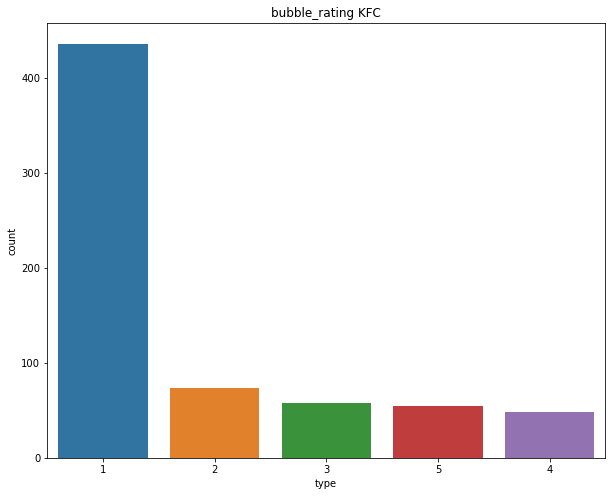

In [ ]:
import seaborn as sns
sns.countplot(
  x='bubble_rating',
  data=data_clean1,
  order=data_clean1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating KFC");

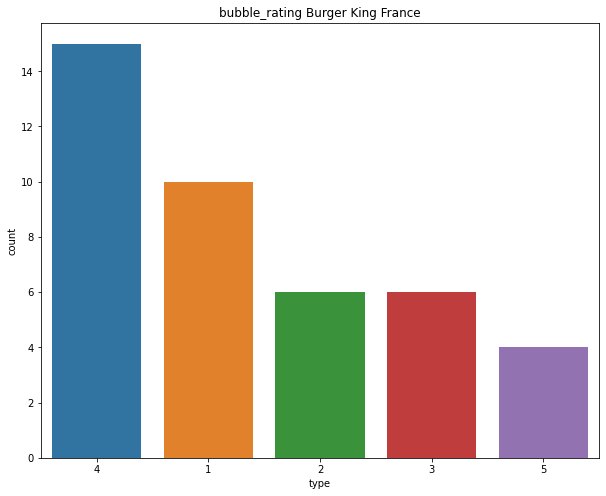

In [ ]:
import seaborn as sns
sns.countplot(
  x='bubble_rating',
  data=data_clean_bk1,
  order=data_clean_bk1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating Burger King France");

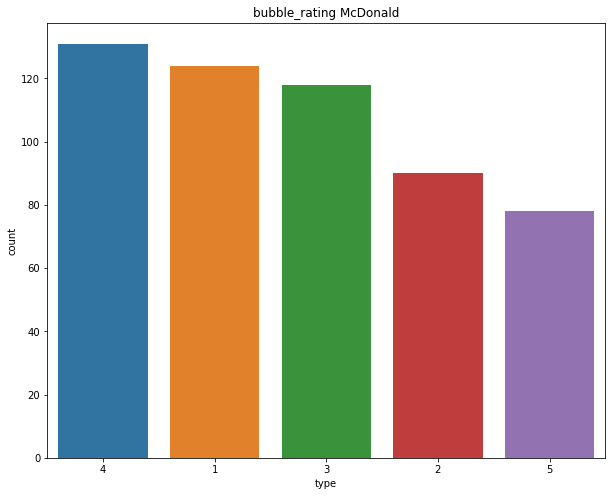

In [ ]:
import seaborn as sns
sns.countplot(
  x='bubble_rating',
  data=data_clean_km1,
  order=data_clean_km1.bubble_rating.value_counts().index
)

plt.xlabel("type")
plt.title("bubble_rating McDonald");

### Interprétation 


* D'après ces 3 graphes on remarque que pour KFC il y a un nombre important de clients ont donné un retour négatif sur KFC (1 étoile).
* Tandis que pour Burger King on remarque que les retours positives sont plues sur les retours négatives .
* Pour Mcdo, on remarque une grande différence par rapport aux deux autres restaurants. La majorité des cients ont attribué une note de 4  et on trouve aussi la note 5 

In [ ]:
data_clean_bk1["review_type"] = data_clean_bk1["bubble_rating"].apply(
  lambda x: "bad" if x < 3 else "good"
)

In [ ]:
data_clean_km1["review_type"] = data_clean_km1["bubble_rating"].apply(
  lambda x: "bad" if x < 3 else "good"
)

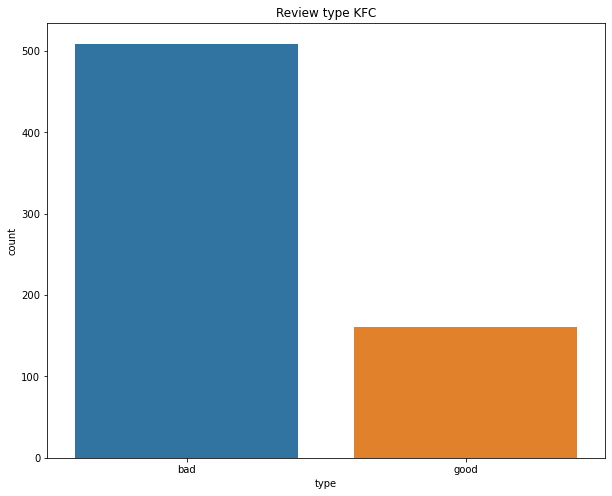

In [ ]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean1,
  order=data_clean1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type KFC");

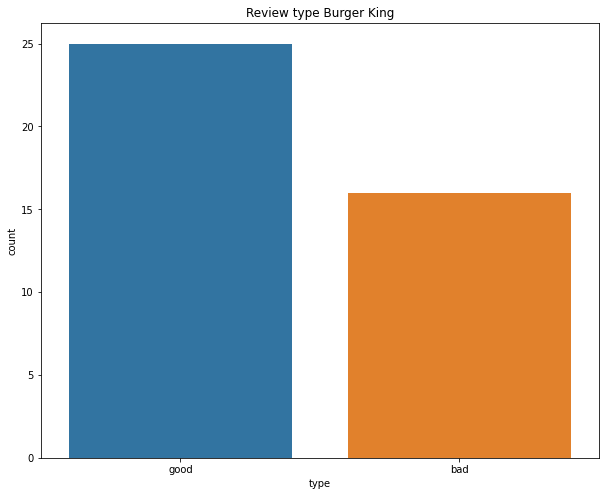

In [ ]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean_bk1,
  order=data_clean_bk1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type Burger King");

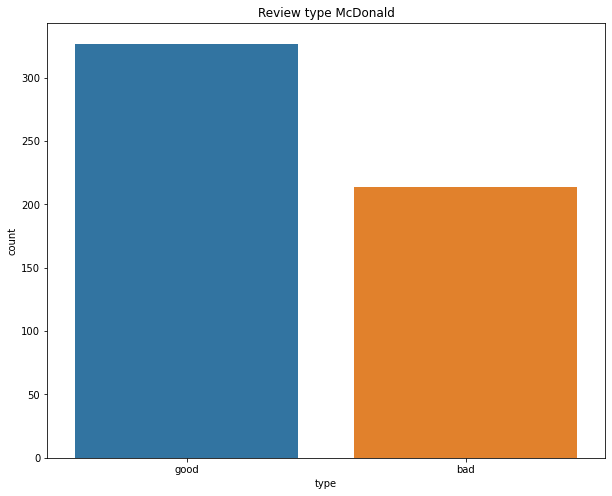

In [ ]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=data_clean_km1,
  order=data_clean_km1.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type McDonald");

### Interprétation

* Pour KFC la plupart des clients ont donné des retours négatifs.
* Pour Burger King la pourcentage des clients avec des retours positifs a augmenté.
* Pour MacDo il ya tant de retours positifs que négatifs.  
* Donc ces 3 graphes confirment plus nos intreprétations précédentes. 

## 2 ème méthode: Evaluation de l'image de KFC France en focalusiant sur les textes "des reviews"

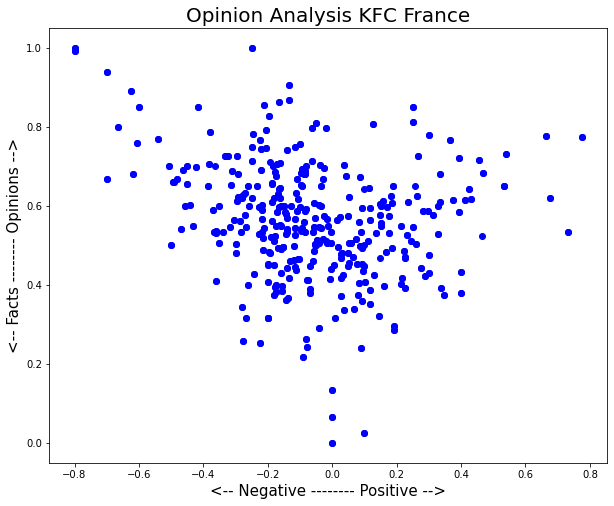

In [ ]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean['polarity'] = data_clean['The review'].apply(pol)
data_clean['subjectivity'] = data_clean['The review'].apply(sub)
data_clean["Reviewer Name"]=df["reviewer_name"]

# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean.index):
    x = data_clean.polarity.loc[index]
    y = data_clean.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis KFC France', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

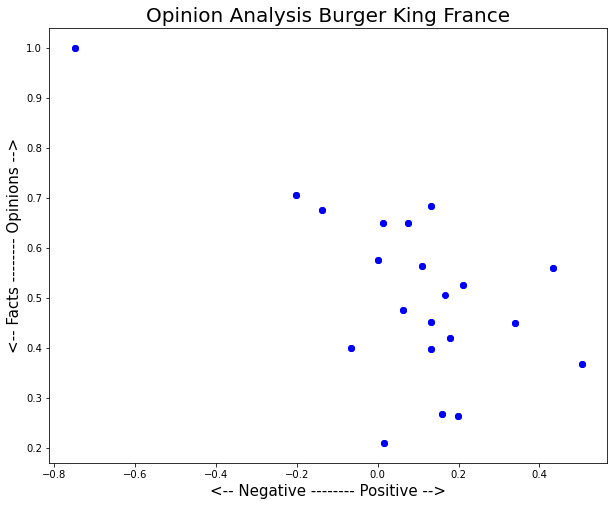

In [ ]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean_bk['polarity'] = data_clean_bk['The review'].apply(pol)
data_clean_bk['subjectivity'] = data_clean_bk['The review'].apply(sub)
data_clean_bk["Reviewer Name"]=df_bk["reviewer_name"]

# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean_bk.index):
    x = data_clean_bk.polarity.loc[index]
    y = data_clean_bk.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis Burger King France', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

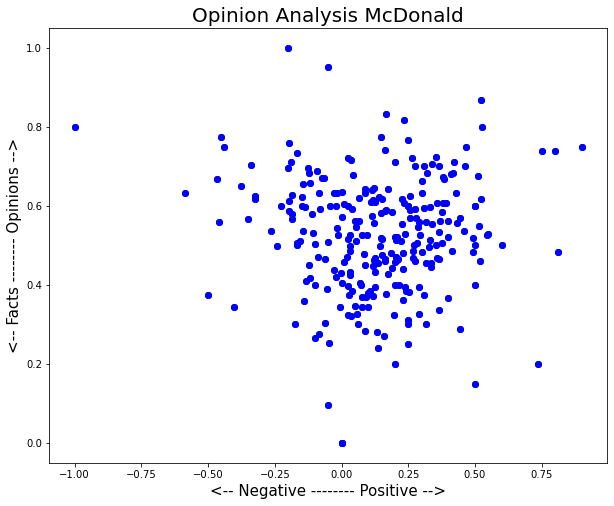

In [ ]:
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data_clean_km['polarity'] = data_clean_km['The review'].apply(pol)
data_clean_km['subjectivity'] = data_clean_km['The review'].apply(sub)
data_clean_km["Reviewer Name"]=df_km["reviewer_name"]

# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data_clean_km.index):
    x = data_clean_km.polarity.loc[index]
    y = data_clean_km.subjectivity.loc[index]
    plt.scatter(x, y, color='blue')
    #plt.text(x+.001, y+.001, data_clean['Reviewer Name'][index], fontsize=10)
    #plt.xlim(-.01, .12) 
    
plt.title('Opinion Analysis McDonald', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

### Interprétation

* D'après ces trois graphes on remarque que pour Burger King le nombre de clients dont la polarité est négative est très inférieurs de celui des clients de KFC.
* Et pour Mcdonald l on peut voir que presque la totalité des clients ont écrit des textes dont la polarité est positive.
* Ces graphes confirment d'avantages tous les interprétations précédentes.

### Interprétation générale

D'après tous les analyses qu'on a effectué sur les retours et les notes donnés par les clients de trois restaurants concurrents (MacDonald's, Burger King et King Marcel France) on remarque que la réputation de MacDo est la plus mauvaise. 